In [1]:
import sys, os
sys.path.append(os.path.abspath("modules"))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch,ArrowStyle
import matplotlib.patheffects as pe
from matplotlib.colors import Normalize
from matplotlib import cm
#from highlight_text.htext import htext, fig_htext

import importing_sb as imsb
import draw_pitch as dp

%matplotlib inline

In [2]:
data_dir = 'data/open-data/data/'

In [3]:
comp_data = imsb.open_data(data_dir + 'competitions.json')

In [4]:
# comp_id = 11 is La Liga, season_id = 4 is 18/19
match_data = sorted(imsb.open_data(data_dir + 'matches/11/4.json'), key = lambda x: x['match_date'])

In [5]:
event_data = []
lineup_data =[]
for match in match_data:
    event_data.append(imsb.open_data(data_dir + 'events/{}.json'.format(match['match_id'])))
    lineup_data.append(imsb.open_data(data_dir + 'lineups/{}.json'.format(match['match_id'])))

In [6]:
nicknames = {}
for match in lineup_data:
    for team in match:
        if team['team_name'] == 'Barcelona':
            for players in team['lineup']:
                if players['player_nickname'] == None:
                    nicknames[str(players['player_name'])] = str(players['player_name'])
                else:
                    nicknames[str(players['player_name'])] = str(players['player_nickname'])

To begin I will use the first match of the of the La Liga 18/19 season for testing.

In [7]:
# Find the starting 11 and shirt numbers
for i in range(2):
    if event_data[0][i]['team']['name'] == 'Barcelona':
        players = [player['player']['name'] for player in event_data[0][i]['tactics']['lineup']]
        numbers = [number['jersey_number'] for number in event_data[0][i]['tactics']['lineup']]

In [8]:
df_numbers = pd.Series(numbers,index=players)

In [9]:
df = imsb.get_pass(event_data[0])
df['y'] = df['y'].apply(lambda y: 80-y) # Flipping y coord for plotting
df['end_y'] = df['end_y'].apply(lambda y: 80-y) # Flipping y coord for plotting
df = df[df['outcome'] == 'Complete'] # Taking only complete passes
df = df[df['pass_type'] == 'Standard'] # Only standard, open play passes
df = df[df['team'] == 'Barcelona'] # Only Barca passes
df = df[df['player'].isin(players)] # keep passers only in starting 11
df = df[df['recipient'].isin(players)] # keep recipients only in starting 11
df.drop(['index','event_id','minute','second','type','duration','cross','cutback','switch','technique'],axis=1,
       inplace=True)

In [10]:
df.columns

Index(['period', 'pos_team', 'play_pattern', 'team', 'player', 'x', 'y',
       'end_x', 'end_y', 'length', 'angle', 'height', 'recipient',
       'under_pressure', 'shot_assist', 'goal_assist', 'xA', 'body_part',
       'pass_type', 'outcome', 'progressive'],
      dtype='object')

Get average player positions of the starting 11 using the positions the played and received passes.

In [12]:
# Create df where index is player name with average x and y columns
x_list = []
y_list = []
player_loc = pd.DataFrame(index=players)
for player in players:
    loc1 = df[df['player'] == player][['x','y']]
    loc2 = df[df['recipient'] == player][['end_x','end_y']].rename(columns={'end_x':'x','end_y':'y'})
    loc = pd.concat([loc1,loc2]).mean()
    x_list.append(loc['x'])
    y_list.append(loc['y'])
player_loc['x'] = x_list
player_loc['y'] = y_list

## Separating pass amounts by passer and receiver

In [13]:
df_player = df.set_index(['player','recipient']).sort_index()

In [14]:
df_player_count = df.groupby(['player','recipient']).size()

## Using total passes between players

For this plot I will use the total amount of passes between pairs of players, disregarding the specifics of passer and receiver.

In [15]:
player_list = []
player1 = []
player2 = []
total = []
for i in players:
    for j in players:
        if j in player_list:
            continue
        if i == j:
            continue
        if j in df_player_count.loc[i].index and i in df_player_count.loc[j].index:
            player1.append(i)
            player2.append(j)
            total.append(df_player_count.loc[i,j]+df_player_count.loc[j,i])
        elif j in df_player_count[i].index and i not in df_player_count.loc[j].index:
            player1.append(i)
            player2.append(j)
            total.append(df_player_count.loc[i,j])
        elif j not in df_player_count.loc[i].index and i in df_player_count.loc[j].index:
            player1.append(i)
            player2.append(j)
            total.append(df_player_count.loc[j,i])
            
    player_list.append(i)

In [16]:
df_total = pd.DataFrame({'player1':player1,'player2':player2,'total':total})

In [17]:
def change_range(value,old_range,new_range):
    return ((value - old_range[0])/(old_range[1]-old_range[0])) * (new_range[1]-new_range[0]) + new_range[0]

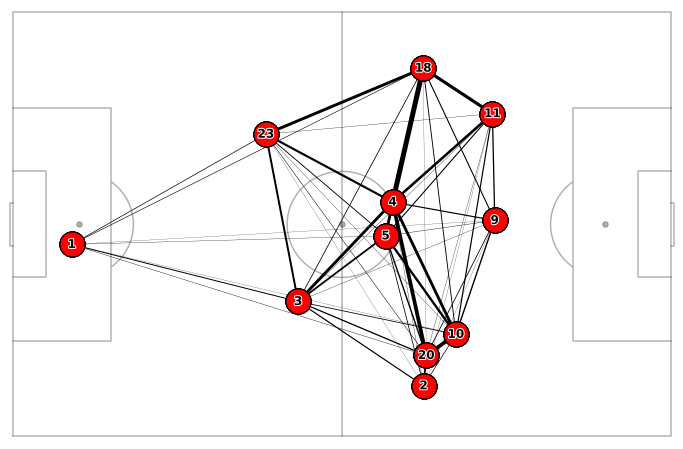

In [18]:
max_pair_count = df_total['total'].max()
max_edge_width = 5
min_edge_width = 0.1

fig,ax = dp.draw_pitch('w','k','h','f',alpha=0.3)
for i,row in df_total.iterrows():
    p1 = row['player1']
    p2 = row['player2']
    loc = [[player_loc.loc[p1]['x'],player_loc.loc[p2]['x']],[player_loc.loc[p1]['y'],player_loc.loc[p2]['y']]]
    num_passes = row['total']
    # Plot nodes
    ax.plot(loc[0],loc[1],'.',markersize=50,c='r',mec='k',zorder=10)
    # Plot edges
    line_width = change_range(num_passes,(0,max_pair_count),(min_edge_width,max_edge_width))
    ax.plot(loc[0],loc[1],'k-',lw=line_width,zorder=9)
    
for i,value in df_numbers.iteritems():
    ax.annotate(value,(player_loc.loc[i]['x'],player_loc.loc[i]['y']),ha='center',va='center',size=12,
                fontweight='bold',path_effects=[pe.withStroke(linewidth=2,foreground='w')],zorder=12)

Pass amount by colour.

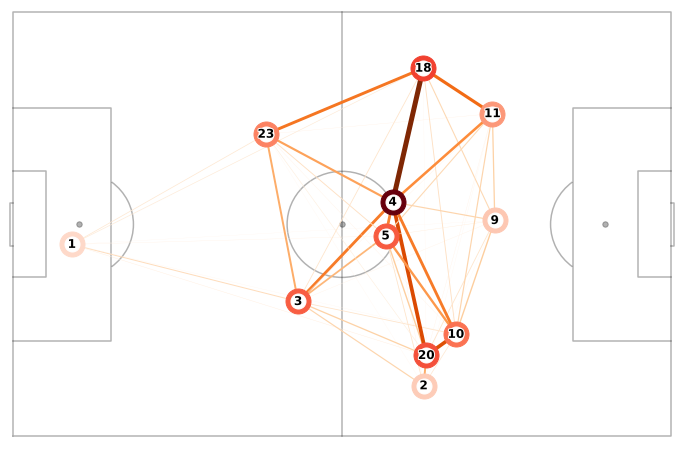

In [19]:
max_play_count = df.groupby('player').size().max()
min_play_count = df.groupby('player').size().min()
max_pair_count = df_total['total'].max()
max_edge_width = 5
min_edge_width = 0.1

fig,ax = dp.draw_pitch('w','k','h','f',alpha=0.3)

# Plot nodes
node_norm = Normalize(0,max_play_count)
node_cmap = cm.get_cmap('Reds')
for i,value in df.groupby('player').size().iteritems():
    loc = [player_loc.loc[i]['x'],player_loc.loc[i]['y']]
    marker_size = 50
    inner_marker_size = 30
    node_colour = node_cmap(node_norm(value))
    ax.plot(loc[0],loc[1],'.',markersize=marker_size,c=node_colour,zorder=10)
    ax.plot(loc[0],loc[1],'.',markersize=inner_marker_size,c='w',zorder=11)

# Plot edges
edge_norm = Normalize(0,max_pair_count)
edge_cmap = cm.get_cmap('Oranges')
for i,row in df_total.iterrows():
    p1 = row['player1']
    p2 = row['player2']
    loc = [[player_loc.loc[p1]['x'],player_loc.loc[p2]['x']],[player_loc.loc[p1]['y'],player_loc.loc[p2]['y']]]
    num_passes = row['total']
    edge_colour = edge_cmap(edge_norm(num_passes))
    line_width = change_range(num_passes,(0,max_pair_count),(min_edge_width,max_edge_width))
    ax.plot(loc[0],loc[1],'k-',lw=line_width,c=edge_colour,zorder=9)

# Annotation
for i,value in df_numbers.iteritems():
    ax.annotate(value,(player_loc.loc[i]['x'],player_loc.loc[i]['y']),ha='center',va='center',size=12,
                fontweight='bold',path_effects=[pe.withStroke(linewidth=2,foreground='w')],zorder=12)

## Separating by passer and recipient

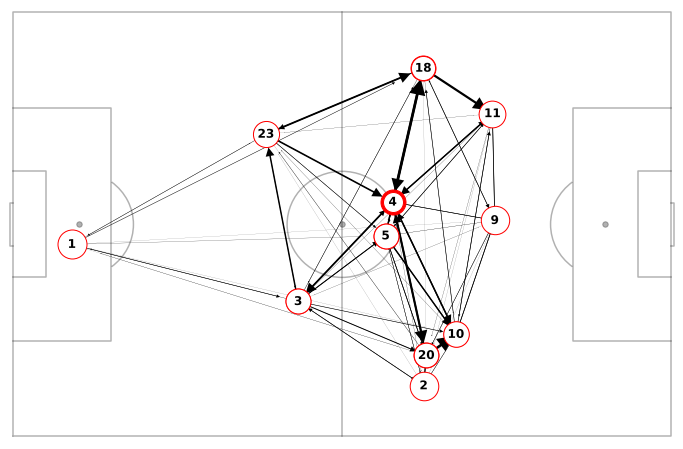

In [20]:
max_play_count = df.groupby('player').size().max()
min_play_count = df.groupby('player').size().min()
max_pair_count = df_player_count.max()
max_edge_width = 0.5
min_edge_width = 0
max_inner_node_size = 40
min_inner_node_size = 58
max_node_size = 70
min_node_size = 40

fig,ax = dp.draw_pitch('w','k','h','f',alpha=0.3)
for i,value in df.groupby('player').size().iteritems():
    loc = [player_loc.loc[i]['x'],player_loc.loc[i]['y']]
    marker_size = 50#change_range(value,(min_play_count,max_play_count),(min_node_size,max_node_size))
    inner_marker_size = change_range(value,(min_play_count,max_play_count),(min_inner_node_size,max_inner_node_size))
    ax.plot(loc[0],loc[1],'.',markersize=marker_size,c='r',mec='r',mew=1,zorder=10)
    ax.plot(loc[0],loc[1],'.',markersize=inner_marker_size,
            c='w',mec='r',mew=1,zorder=11)

for i,value in df_player_count.iteritems():
    p1 = i[0]
    p2 = i[1]
    loc = [[player_loc.loc[p1]['x'],player_loc.loc[p2]['x']],[player_loc.loc[p1]['y'],player_loc.loc[p2]['y']]]
    num_passes = value
    # Plot edges
    line_width = change_range(num_passes,(0,max_pair_count),(min_edge_width,max_edge_width))
    ax.arrow(loc[0][0],loc[1][0],0.92*(loc[0][1]-loc[0][0]),0.92*(loc[1][1]-loc[1][0]),
             length_includes_head=True,width=line_width,head_width=6*line_width,
             head_length=6*line_width,fc='k',lw=0)

for i,value in df_numbers.iteritems():
    ax.annotate(value,(player_loc.loc[i]['x'],player_loc.loc[i]['y']),ha='center',va='center',size=12,
                fontweight='bold',path_effects=[pe.withStroke(linewidth=2,foreground='w')],zorder=12)
    
#style = ArrowStyle("Simple",head_length=10, head_width=10, tail_width=2)
#arrow = FancyArrowPatch((loc[0][0],loc[1][0]),(loc[0][1],loc[1][1]),arrowstyle=style,mutation_scale=1,fc='k')
#ax.add_patch(arrow)